# P2: CNN
## Transfer learning

Esta práctica consistirá en implementar un clasificador de imágenes similar a la Práctica 1. En este caso utilizaremos una arquitectura basada en CNNs, y el proceso de entrenamiento seguirá una estrategia basada en transferencia de conocimiento (transfer learning). Utilizaremos un modelo preentrenado en un conjunto de datos grande (ImageNet) y modificando únicamente la última capa del clasificador adaptando el modelo a un nuevo problema. Al aprovechar características ya aprendidas, se reduce el tiempo de entrenamiento, se optimizan recursos y se mejora el rendimiento incluso con datos escasos.

Dado que se trata de un modelo más grande que la práctica 1, es recomendable realizar el entrenamiento en GPU. Para ello, podemos seleccionar un entorno de ejecución con GPU directamente en Google Colab. Recordar mover tanto el modelo como los datos de entrada a memoria de GPU para utilizar esta GPU y no realizar el entrenamiento/inferencia en CPU.

## Importar paquetes necesarios.

In [1]:
!pip install --upgrade torchinfo

In [2]:
!pip install kagglehub

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from torchinfo import summary
from PIL import Image
from tempfile import TemporaryDirectory
import torch.nn.functional as F
plt.ion()   # interactive mode

## Conjunto de Datos
En primer lugar, descargaremos el conjunto de datos de entrenamiento y validación. Se trata de un conjunto de datos disponible en kaggle: https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals

La siguiente celda descarga este conjunto de datos directamente de Kaggle.

In [4]:
import kagglehub
#https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals
# Download latest version
path = kagglehub.dataset_download("iamsouravbanerjee/animal-image-dataset-90-different-animals")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals/versions/5


El conjunto de datos contiene una carpeta para cada una de las 90 categorías, y cada carpeta contiene todas las imágenes etiquetadas como la correspondiente categoría. Puedes explorar el árbol de directorios con comandos Bash, o directamente utilizando el explorador de archivos de Google Colab (disponible en la barra de herramientas izquierda).

In [5]:
# !ls
!ls /root/.cache/kagglehub/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals/versions/5/animals/animals

antelope     cockroach	elephant     hippopotamus  lobster    parrot	      seahorse	turtle
badger	     cow	flamingo     hornbill	   mosquito   pelecaniformes  seal	whale
bat	     coyote	fly	     horse	   moth       penguin	      shark	wolf
bear	     crab	fox	     hummingbird   mouse      pig	      sheep	wombat
bee	     crow	goat	     hyena	   octopus    pigeon	      snake	woodpecker
beetle	     deer	goldfish     jellyfish	   okapi      porcupine       sparrow	zebra
bison	     dog	goose	     kangaroo	   orangutan  possum	      squid
boar	     dolphin	gorilla      koala	   otter      raccoon	      squirrel
butterfly    donkey	grasshopper  ladybugs	   owl	      rat	      starfish
cat	     dragonfly	hamster      leopard	   ox	      reindeer	      swan
caterpillar  duck	hare	     lion	   oyster     rhinoceros      tiger
chimpanzee   eagle	hedgehog     lizard	   panda      sandpiper       turkey


## Lectura de datos
Principales pasos que se deben implementar:
1. Debéis tener en cuenta las siguientes consideraciones para el preprocesamiento de las imágenes:
  - El tamaño de entrada de las imágenes debe ser constante, en nuestro caso utilizaremos una resolución de 224x224.
  - Se deben aplicar técnicas de aumentado de datos básicas
  - Se deben normalizar los datos de entrada. Utilizaremos los siguientes datos para la normalización, extraídos del conjunto de entrenamiento de ImagenNet y ampliamente utilizados en el procesamiento de imágenes:
    - Media: [0.485, 0.456, 0.406]
    - Desviación estándar: [0.229, 0.224, 0.225]

1. Utilizaremos la clase `ImageFolder` de `torchvision` para cargar el dataset descargado previamente.

1. Dado que solo tenemos conjuntos de datos unificado, dividiremos el conjunto de datos en entrenamiento, validación y test, para ello podéis utilizar la función `random_split`.

1. Por último debemos crear los `DataLoader` para los tres conjuntos de datos.


In [6]:
# Data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomCrop(224),  # Recorte random para entrenar a 224x224
        transforms.RandomHorizontalFlip(),  # Volteo horizontal aleatorio, ayuda a aumentar la diversidad de entrenamiento
        transforms.ToTensor(),  # Convertir a tensor con dimensiones (3,224,224)
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización para cada canal (rojo,azul y verde)
    ]),
    #Val se usa para evaluar el rendimiento del modelo después de cada época de entrenamiento, sin influir en la actualización de los pesos,
    #por ello no tiene cabida el randomflip
    'val': transforms.Compose([ #PREGUNTAR SI ES NECESARIO RANDOMHORIZONTALFLIP en validacion tambien
        transforms.CenterCrop(224),  # Recorte centrado a 224x224
        transforms.ToTensor(),  # Convertir a tensor con dimensiones (3,224,224)
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización para cada canal (rojo,azul y verde)
    ]),
}


data_dir = '/root/.cache/kagglehub/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals/versions/5/animals/animals'
#Es muy importante que el path llegue hasta el parent directory, es decir, la carpeta que contiene toda la estructura del dataset
# Create an ImageFolder dataset
full_dataset = datasets.ImageFolder(root=data_dir) #Cargamos el dataset, no realizmos todavía ninguna transformación
class_names = full_dataset.classes                 #Obtenemos las clases del dataset

# Define the train-validation-test split size
train_ratio= 0.7
val_ratio= 0.15
test_ratio= 0.15
train_size = int(train_ratio *len(full_dataset)) #Es OBLIGATORIO que el size sea un INT para usarlo en random_split
val_size = int(val_ratio *len(full_dataset))
test_size = int(len(full_dataset)-val_size-train_size)


# Split the dataset into train and validation sets
train_dataset, val_dataset, test_dataset =random_split(full_dataset,[train_size, val_size, test_size]) #No se puede usar seed
#IMPORTANTE random_split() genera objetos de tipo torch.utils.data.Subset, no de tipo ImageFolder, Esto significa
#que train_dataset, val_dataset y test_dataset NO son datasets independientes. Son subconjuntos (subsets) del dataset original (full_dataset).
# Punto clave: train_dataset no tiene directamente las imágenes, sino que "apunta" a full_dataset

# Apply the respective transformations to the train and validation datasets
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']
test_dataset.dataset.transform = data_transforms['val']
#print(train_dataset.dataset is full_dataset) imprimirá: True
#.dataset es lo mismo que full_dataset y .transform  permite realizar transformaciones sobre el dataset

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset), 'test': len(test_dataset)}

# Create DataLoaders for train and validation sets
batch_size = 32
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
}

print(len(train_dataset), len(val_dataset), len(test_dataset))

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

3779 810 811


## Visualización de datos
Antes de hacer pruebas con el modelos visualizaremos las imágenes en un batch para comprobar que se cargan adecuadamente y comprobar el tipo de datos con los que vamos a trabajar.

['caterpillar', 'porcupine', 'goldfish', 'hamster', 'orangutan', 'whale', 'beetle', 'cat', 'hornbill', 'wombat', 'butterfly', 'lion', 'hedgehog', 'pig', 'parrot', 'donkey', 'goose', 'bison', 'zebra', 'fly', 'moth', 'porcupine', 'grasshopper', 'snake', 'elephant', 'turtle', 'hornbill', 'pigeon', 'horse', 'duck', 'jellyfish', 'dolphin']


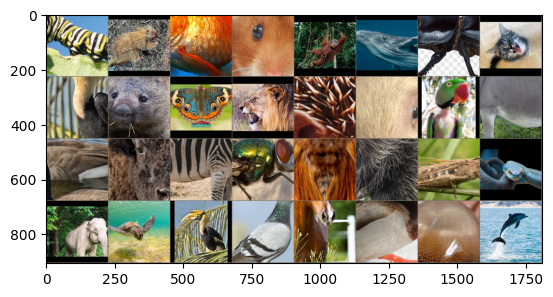

In [16]:

def imshow(img,  mean, std, title=None):
    img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)  #desnormalizar
    #con .view nos aseguramos que el tensor se aplique en el (rgb) de todos los pixeles de la imagen
    npimg = img.numpy() #pasa el tensor a array de numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #En PyTorch las imágenes tienen la forma Canales, Altura, Anchura) y matplotlib las espera como (Altura, Achura, Canales)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

mean = np.array([0.485, 0.456, 0.406]) #Necesario para desnormalizar
std = np.array([0.229, 0.224, 0.225])

print([class_names[x] for x in classes])
imshow(out, mean, std, title=None)

## Exploración de datos

Representa mediante un diagrama de barras el número de ejemplos en el conjunto de entrenamiento para cada una de las categorías. Representa también estos datos para el conjunto de test.

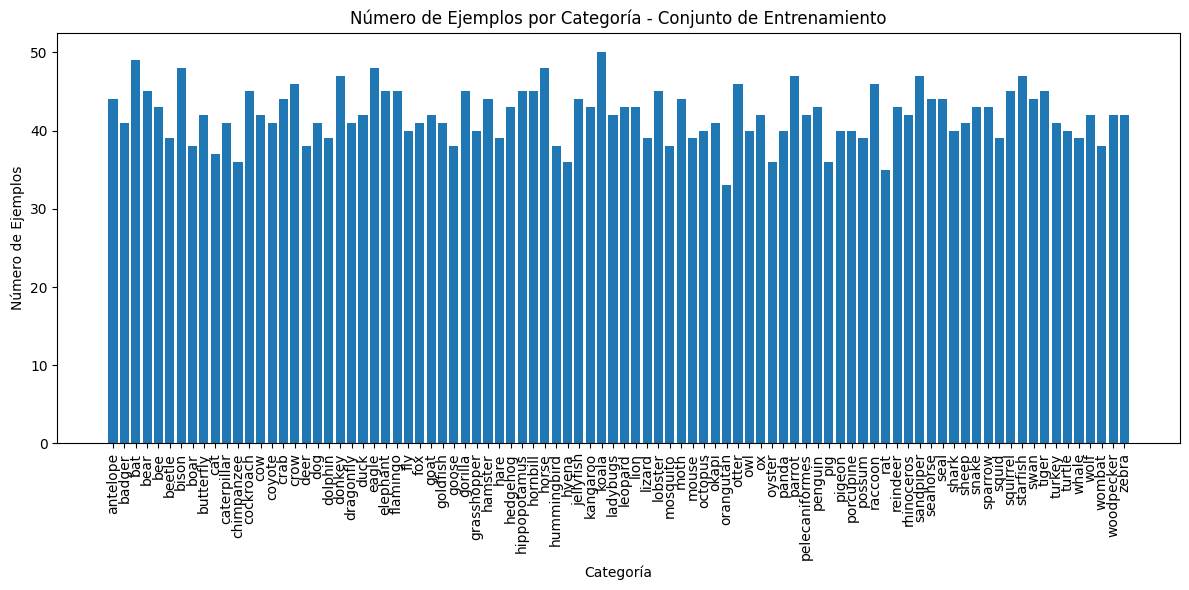

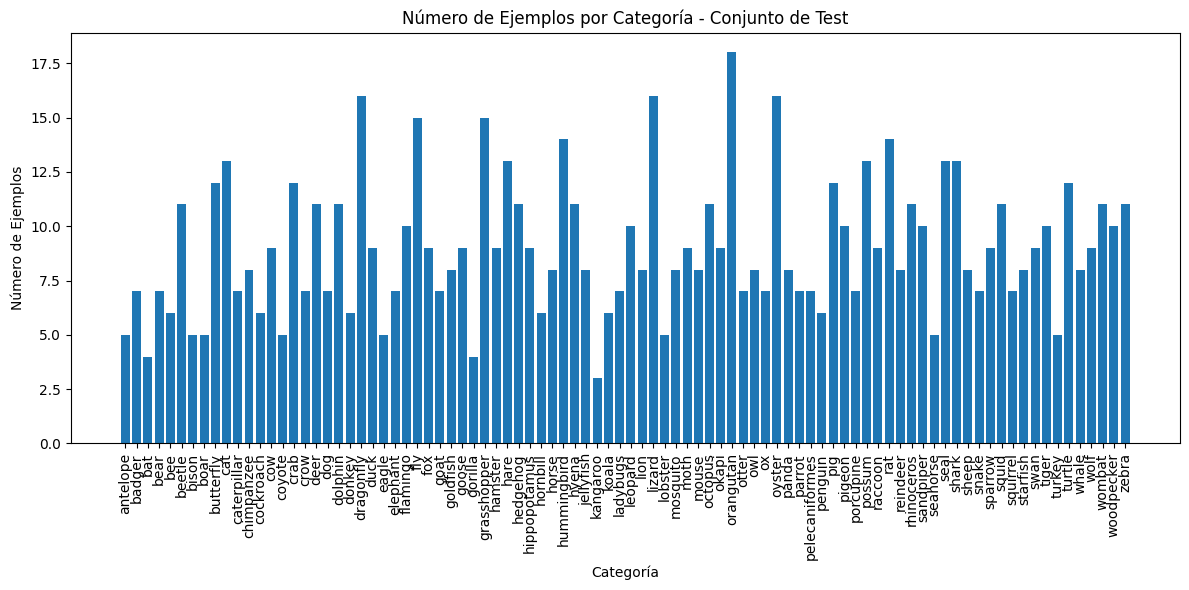

In [ ]:
#TRAIN
labels_train = torch.tensor([i[1] for i in train_dataset])  # Crear un tensor con las etiquetas
# Contar las ocurrencias de cada clase usando torch.bincount
class_counts_train = torch.bincount(labels_train)
# Convertir el tensor de counts a una lista para usarla en el gráfico
class_counts_list_train = class_counts_train.tolist()

plt.figure(figsize=(12, 6))
plt.bar(class_names, class_counts_list_train) #class_names y class_counts_list tienen el mismo orden, por ello se corresponden los nombre con el número
plt.title("Número de Ejemplos por Categoría - Conjunto de Entrenamiento")
plt.xticks(rotation=90)  # Para que las etiquetas de las categorías no se solapen
plt.xlabel("Categoría")
plt.ylabel("Número de Ejemplos")
plt.tight_layout()
plt.show()

#TEST
labels_test = torch.tensor([i[1] for i in test_dataset])  # Crear un tensor con las etiquetas
# Contar las ocurrencias de cada clase usando torch.bincount
class_counts_test = torch.bincount(labels_test)
# Convertir el tensor de counts a una lista para usarla en el gráfico
class_counts_list_test = class_counts_test.tolist()

plt.figure(figsize=(12, 6))
plt.bar(class_names, class_counts_list_test) #class_names y class_counts_list tienen el mismo orden, por ello se corresponden los nombre con el número
plt.title("Número de Ejemplos por Categoría - Conjunto de Test")
plt.xticks(rotation=90)  # Para que las etiquetas de las categorías no se solapen
plt.xlabel("Categoría")
plt.ylabel("Número de Ejemplos")
plt.tight_layout()
plt.show()




## Inicialización
- En este caso, a diferencia de la práctica 1, en lugar de definir cada una de las capas del modelo, utilizaremos un modelo predefinido de torchvision. Utilizaremos un modelo basado en ResNet18 (`torchvision.models.resnet18`). Además, `torchvision` también proporciona pesos de modelos preentrenados, en este caso inicializaremos el modelo con los pesos obtenidos en el conjunto de datos ImageNet 1K (`IMAGENET1K_V1 `).
- Utilizaremos un esquema de transferencia de conocimiento en el que se mantendrán todas las capas convolucionales congeladas y únicamente se optimizarán los parámetros de la última capa totalmente conectada. Se deben realizar los siguientes pasos:
  1. Explorar la estructura del modelo con la función `summary` de `torchinfo`.
  1. Congelar capas convolucionales.
  1. Modificar la última capa totalmente conectada para que el número de neuronas de salida coincida con el número de categorías del nuevo conjunto de datos.
  1. Volver a explorar la estructura del modelo con la función `summary` de `torchinfo` y comparar la salida con la versión inicial del modelo.
- Como función de coste utilizaremos la Entropía Cruzada.
- Como optimizador utilizaremos Descenso de Gradiente Estocástico.
- Definiremos un planificador de la tasa de aprendizaje que reduzca la tasa de aprendizaje en un orden de magnitud en cada paso de reducción. Se deben realizar pruebas comprobando las gráficas de coste y validación para seleccionar tanto la tasa de aprendizaje como el número de épocas en cada paso. Realizaremos una única reducción de la tasa de aprendizaje.


In [7]:
model_conv = torchvision.models.resnet18(pretrained=True) #Mantenemos los parámetro del entrenamiento

#Mantenemos nº de entrada y cambiamos salida al nº de clases de nuestro problema de clasificación
model_conv.fc = torch.nn.Linear(in_features=model_conv.fc.in_features, out_features=len(class_names))

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.003, momentum=0.9)

# ExpLR Scheduler (Reducir tasa de aprendizaje después de cierto número de épocas)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

summary(model_conv, (1, 3, 224, 224)) #(tamaño del batch, canales, altura, anchura) esto es necesario para ver el Output Shape

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 90]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

In [8]:
for name, param in model_conv.named_parameters():
    if name != "fc.weight" and name != "fc.bias": #Freeze excepto en la ultima capa
        param.requires_grad=False

In [9]:
summary(model_conv,(1,3,240,240))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 90]                   --
├─Conv2d: 1-1                            [1, 64, 120, 120]         (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 120, 120]         (128)
├─ReLU: 1-3                              [1, 64, 120, 120]         --
├─MaxPool2d: 1-4                         [1, 64, 60, 60]           --
├─Sequential: 1-5                        [1, 64, 60, 60]           --
│    └─BasicBlock: 2-1                   [1, 64, 60, 60]           --
│    │    └─Conv2d: 3-1                  [1, 64, 60, 60]           (36,864)
│    │    └─BatchNorm2d: 3-2             [1, 64, 60, 60]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 60, 60]           --
│    │    └─Conv2d: 3-4                  [1, 64, 60, 60]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 60, 60]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 60, 60]   

## Observamos que los únicos Trainable params (46,170) son los de la última capa, y todos los demás son Non-trainable params (11,176,512)

## Bucle de entrenamiento
La siguiente función implementará el bucle de entrenamiento, se debe utilizar el conjunto de validación para comprobar el rendimiento del modelo en inferencia después de cada época de entrenamiento. El modelo asociado a la mejor época en validación debe ser almacenado en un archivo `.pt`.

Este bucle de entrenamiento debe soportar la utilización de un esquema de reducción de tasa de aprendizaje (Learning Rate).

In [10]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=25, device="cuda"):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    model.to(device)  # Mover modelo a GPU o CPU

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        avg_train_accuracy = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)

        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)

                loss = criterion(outputs, labels)
                val_loss += loss.item()
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        avg_val_accuracy = correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)


        scheduler.step()

        print(f"Época {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_accuracy:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_accuracy:.4f}")

    return model, train_losses, train_accuracies, val_losses, val_accuracies


## Gráficas de entrenamiento y validación

Representa gráficamente las gráficas de coste tanto en entrenamiento como en validación.

In [11]:
import matplotlib.pyplot as plt

def plot_graficas_entreno_validacion(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Gráfica del loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Loss de entrenamiento')
    plt.plot(epochs, val_losses, label='Loss de validacion')
    plt.xlabel('Epocas')
    plt.ylabel('Loss')
    plt.title('Loss duarnte entrenamiento y validacion')
    plt.legend()

    # Gráfica de la precisión
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Precision de entrenamiento')
    plt.plot(epochs, val_accuracies, label='Precision de validacion')
    plt.xlabel('Epocas')
    plt.ylabel('Precision')
    plt.title('Precision durante entrenamiento y valdiacion')
    plt.legend()

    plt.show()





In [12]:
# ExpLR Scheduler (Reducir tasa de aprendizaje después de cierto número de épocas)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=20, gamma=0.1) #Al ser 15 epocas y el reductor hacerlo cada 20 nunca se produce
model1, train_losses1, train_accuracies1, val_losses1, val_accuracies1  = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, dataloaders["train"], dataloaders["val"], num_epochs=15,device=device)


Época 1/15 - Train Loss: 3.7251, Train Acc: 0.2128, Val Loss: 2.6365, Val Acc: 0.4728
Época 2/15 - Train Loss: 2.1937, Train Acc: 0.5917, Val Loss: 1.8521, Val Acc: 0.6148
Época 3/15 - Train Loss: 1.6237, Train Acc: 0.6941, Val Loss: 1.5137, Val Acc: 0.6716
Época 4/15 - Train Loss: 1.3319, Train Acc: 0.7425, Val Loss: 1.3875, Val Acc: 0.6988
Época 5/15 - Train Loss: 1.1778, Train Acc: 0.7629, Val Loss: 1.2879, Val Acc: 0.7049
Época 6/15 - Train Loss: 1.0603, Train Acc: 0.7798, Val Loss: 1.2463, Val Acc: 0.7074
Época 7/15 - Train Loss: 0.9739, Train Acc: 0.8055, Val Loss: 1.1836, Val Acc: 0.7136
Época 8/15 - Train Loss: 0.9001, Train Acc: 0.8145, Val Loss: 1.1458, Val Acc: 0.7173
Época 9/15 - Train Loss: 0.8372, Train Acc: 0.8280, Val Loss: 1.1271, Val Acc: 0.7235
Época 10/15 - Train Loss: 0.7934, Train Acc: 0.8418, Val Loss: 1.1220, Val Acc: 0.7198
Época 11/15 - Train Loss: 0.7502, Train Acc: 0.8505, Val Loss: 1.1108, Val Acc: 0.7185
Época 12/15 - Train Loss: 0.7122, Train Acc: 0.8531,

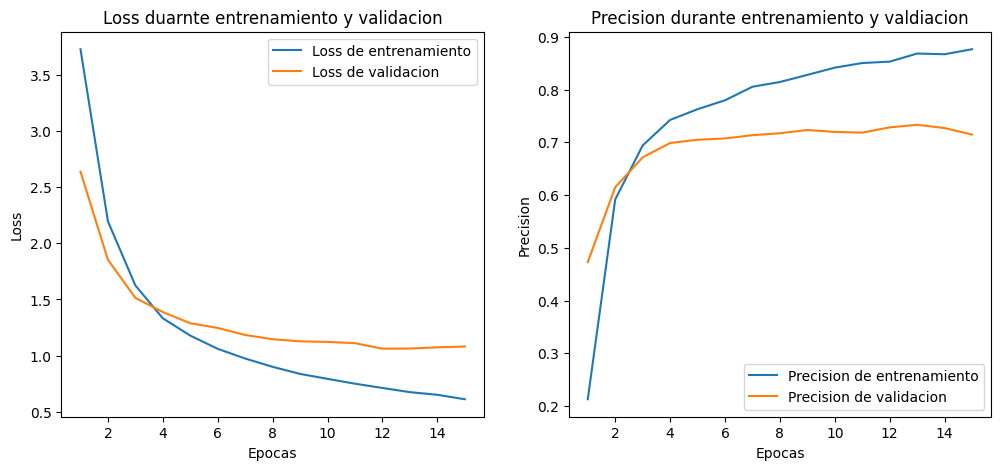

In [13]:
plot_graficas_entreno_validacion(train_losses1,val_losses1, train_accuracies1, val_accuracies1)

Vemos que el modelo se queda estancado en la época 4, a partir de esta época no mejora el Accuracy de validación y solo se sobreajusta. Para mejorar esto vamos a bajar el Learning Rate cada 2 épocas.

In [12]:
# ExpLR Scheduler (Reducir tasa de aprendizaje después de cierto número de épocas)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=2, gamma=0.7) #Reducimos en la epoca 2

model2, train_losses2, train_accuracies2, val_losses2, val_accuracies2  = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, dataloaders["train"], dataloaders["val"], num_epochs=15,device=device)


Época 1/15 - Train Loss: 3.7492, Train Acc: 0.2030, Val Loss: 2.7505, Val Acc: 0.4123
Época 2/15 - Train Loss: 2.2367, Train Acc: 0.5703, Val Loss: 1.8356, Val Acc: 0.6123
Época 3/15 - Train Loss: 1.6556, Train Acc: 0.6909, Val Loss: 1.5952, Val Acc: 0.6469
Época 4/15 - Train Loss: 1.4375, Train Acc: 0.7383, Val Loss: 1.4322, Val Acc: 0.6667
Época 5/15 - Train Loss: 1.2752, Train Acc: 0.7605, Val Loss: 1.3508, Val Acc: 0.6741
Época 6/15 - Train Loss: 1.1874, Train Acc: 0.7798, Val Loss: 1.3237, Val Acc: 0.6877
Época 7/15 - Train Loss: 1.1240, Train Acc: 0.7928, Val Loss: 1.2950, Val Acc: 0.6827
Época 8/15 - Train Loss: 1.0706, Train Acc: 0.7962, Val Loss: 1.2697, Val Acc: 0.6864
Época 9/15 - Train Loss: 1.0357, Train Acc: 0.8097, Val Loss: 1.2355, Val Acc: 0.6951
Época 10/15 - Train Loss: 1.0115, Train Acc: 0.8074, Val Loss: 1.2189, Val Acc: 0.6901
Época 11/15 - Train Loss: 0.9941, Train Acc: 0.8153, Val Loss: 1.2069, Val Acc: 0.6938
Época 12/15 - Train Loss: 0.9741, Train Acc: 0.8261,

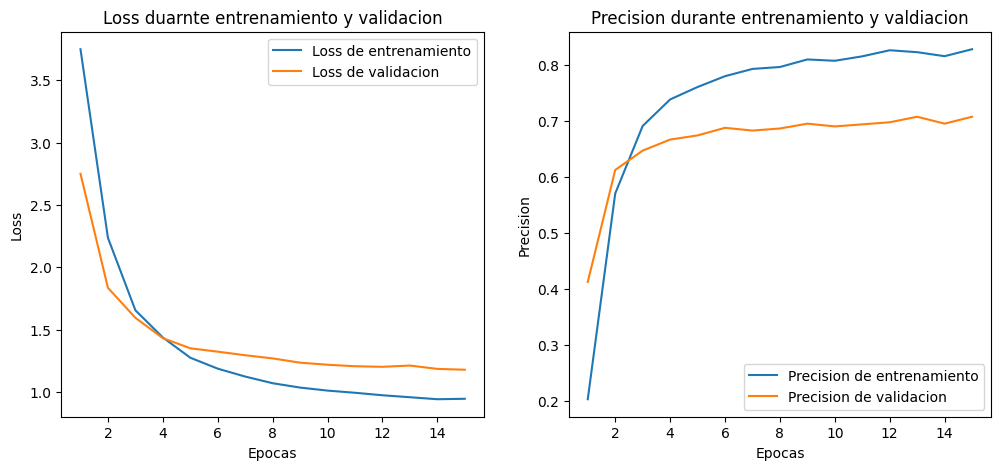

In [13]:
plot_graficas_entreno_validacion(train_losses2,val_losses2, train_accuracies2, val_accuracies2)

## Inferencia y visualización de resultados

Calcular `Accuracy` en inferencia.

Visualizar la predicción del modelo para las primeras 10 imágenes de test, proporcionando las 5 categorías más probables para cada imagen.

In [21]:
def evaluate_model(model, test_loader, device="cuda"):
    model.to(device)  # Asegurar que el modelo esté en la GPU/CPU correcta
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Mover datos a la GPU/CPU
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy



def visualize_model(model, test_loader, class_names, mean, std, num_images=10, device="cuda:0"):
    model.to(device)  # Mover modelo a la GPU/CPU correcta
    model.eval()

    images_shown = 0
    fig = plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Mover datos a GPU
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            top5_prob, top5_classes = torch.topk(probabilities, 5, dim=1)

            for i in range(images.shape[0]):
                if images_shown >= num_images:
                    return
                ax = plt.subplot(2, 5, images_shown + 1)
                ax.axis('off')
                title_text = f"GT: {class_names[labels[i]]}\nPred: {class_names[top5_classes[i][0]]}"
                title_text += "\n" + "\n".join([f"{class_names[top5_classes[i][j]]}: {top5_prob[i][j]:.2f}" for j in range(5)])
                ax.set_title(title_text)

                img = images[i].cpu().permute(1, 2, 0).numpy()  # Convertir a numpy para visualizar
                img = img * std + mean  # Desnormalizar
                img = np.clip(img, 0, 1)  # Asegurar que los valores estén entre 0 y 1

                plt.imshow(img)
                images_shown += 1


Test Accuracy: 74.23%


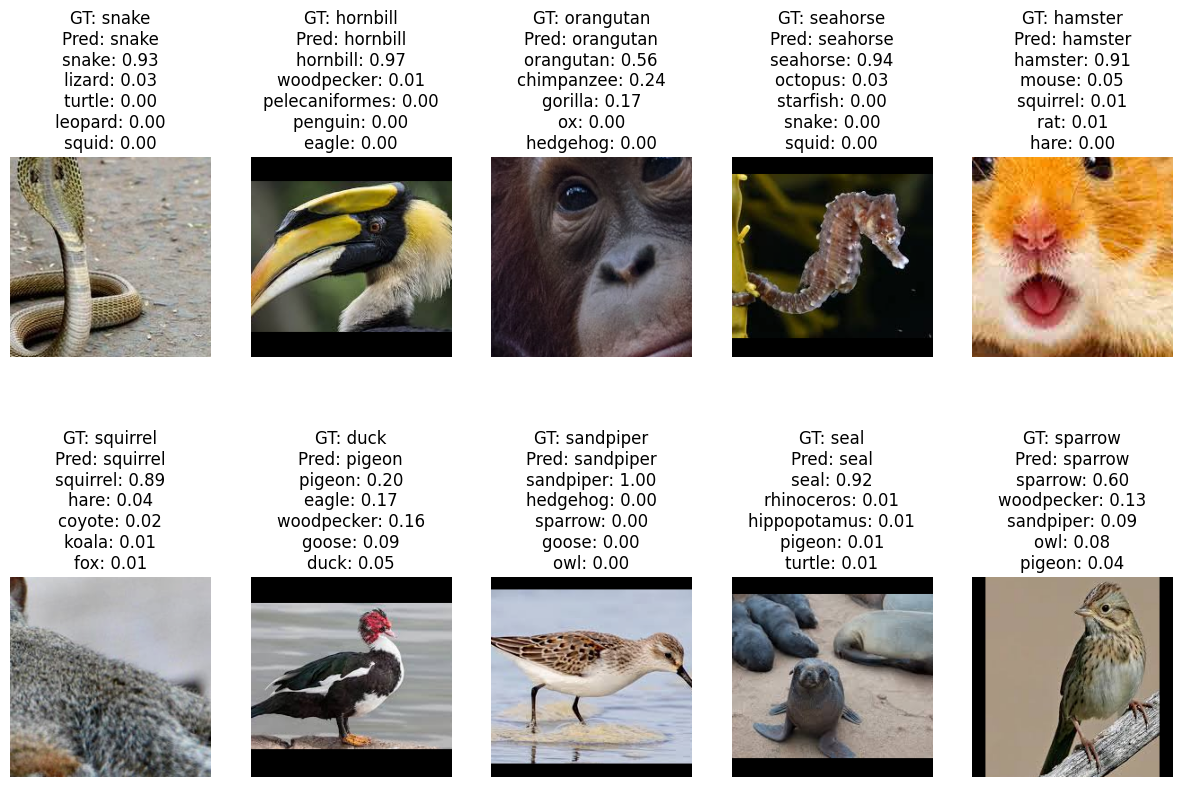

In [22]:
# Definir mean y std para desnormalización
mean = np.array([0.485, 0.456, 0.406]) # Necesario para desnormalizar
std = np.array([0.229, 0.224, 0.225])

evaluate_model(model_conv, dataloaders['test'])
visualize_model(model_conv, dataloaders['test'], class_names, mean, std)